Installing the required packages of keras-core and updating other packages for the project

In [ ]:
! pip install keras-core

In [ ]:
! pip install keras-nlp --upgrade

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
from keras.optimizers import Adam
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plotter
import warnings
warnings.filterwarnings('ignore')

<a id="2"></a>
# **<center><span style="color:#005dc4;">Read Dataset</span></center>**

# Read a CSV file into a DataFrame using pandas
# The CSV file is located at "/content/sample_data/train.csv"

In [ ]:
train = pd.read_csv("/content/sample_data/train.csv")
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


# Check for missing (null) values in the 'train' DataFrame
# The .isnull() method returns a DataFrame of boolean values, where True represents missing values.
# The .sum() method is used to count the missing values for each column.

In [ ]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
#Delete all the duplicates
train.drop_duplicates(inplace=True)

train.shape

(7613, 5)

In [ ]:
#Removing HTML tags
from bs4 import BeautifulSoup

def remove_HTML_Tags(text):
    soup=BeautifulSoup(text,'html.parser')
    return soup.get_text()

train['text']=train['text'].apply(remove_HTML_Tags)

In [ ]:
test = pd.read_csv("/content/sample_data/test.csv")
test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import re
import spacy
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from concurrent.futures import ProcessPoolExecutor

In [ ]:
# Load english lemmas
spacy_process = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Compile regex pattern
pattern = re.compile(r'\b([a-zA-Z])\b')

# Set english stopwords such
stop_words = set(stopwords.words('english'))

In [ ]:
def get_processed_text(text):
    """
    Return lemmatized text without single letters and frequent stopwords.
    Everything is in the lower case register.

    Args:
        text (str): text of an article
    Returns:
        string: text of clean lemmas
    """
    # Convert to lowercase single letters
    text = pattern.sub('', text.lower())

    # Get lemma tokens
    lemmas = spacy_process(text)
    lemmas = [token.lemma_ for token in lemmas if token.text not in stop_words]

    return ' '.join(lemmas)

def get_clean_text(texts):
    """
    Return list of cleaned texts.
    Execution in parallel.

    Args:
        texts: numpy array of string elements
    Returns:
        list: list of cleaned lemmatized tokens
    """
    # Set up parallel tasks processing
    with ProcessPoolExecutor() as executor:
        clean_texts = list(executor.map(get_processed_text, texts))

    return clean_texts

In [ ]:
# Get cleaned train and test texts
train_text_clean = get_clean_text(train['text'].values)
test_text_clean = get_clean_text(test['text'].values)

In [ ]:
# Set clean train and test dataframes with classes
train_data_clean = pd.DataFrame({
    'text': train_text_clean
    , 'target': train['target'].values
})
test_data_clean = pd.DataFrame({
    'text': test_text_clean
})

In [ ]:
# Cleaning
del spacy_process, pattern, stop_words
del get_clean_text, get_processed_text

<a id="3"></a>
# **<center><span style="color:#005dc4;">Preprocessing</span></center>**

# Add a new column "length" to the 'train' DataFrame
# This column will store the length of each text entry in the "text" column.

# Use the .apply() method to apply a lambda function to each entry in the "text" column.
# The lambda function calculates the length of the text entry and stores it in the "length" column.

# Display the updated 'train' DataFrame with the new "length" column.



In [ ]:
train["length"] = train_data_clean["text"].apply(lambda x : len(x))
train

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,45
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,39
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,85
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,60
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,59
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,74
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,93
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,66
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,112


<a id="3"></a>
# **<center><span style="color:#005dc4;">Visualization</span></center>**

# Create a count plot using Seaborn to visualize the distribution of values in the "target" column of the 'train' DataFrame.
# The x-axis represents the "target" values, and the palette is set to "husl" for color.

# Use the .xticks() function to display the x-axis ticks for better readability.


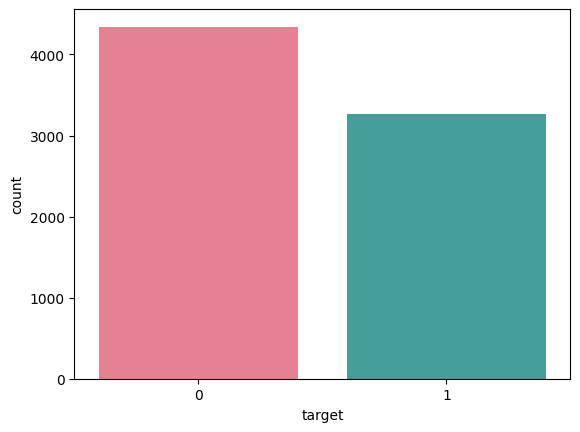

In [ ]:
sns.countplot(x = train["target"], palette="husl")
plotter.xticks();

<Axes: xlabel='length', ylabel='Count'>

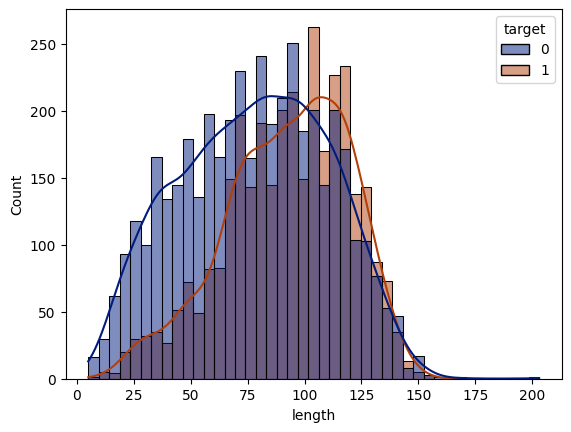

In [ ]:
sns.histplot(train,x='length',hue='target',kde=True,palette="dark")

In [ ]:
test["length"] = test_data_clean["text"].apply(lambda x : len(x))
test

,id,keyword,location,text,length
0,0,NaN,NaN,Just happened a terrible car crash,27
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",55
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",59
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,42
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,37
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,54
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,114
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,53
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,65


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

<a id="4"></a>
# **<center><span style="color:#005dc4;">Preprocessing</span></center>**

In [ ]:
# Define constants and parameters for training and data processing
# Define the batch size for training dataBATCH_SIZE = 32

NUM_TRAINING_EXAMPLES = train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
# Calculate the number of steps per epoch for training based on the training split and batch size
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

 <a id="5"></a>
# **<center><span style="color:#005dc4;">Split Dataset</span></center>**

# Prepare the data for training and testing
# Extract the "text" column from the 'train' DataFrame as the feature (X)
# Extract the "target" column from the 'train' DataFrame as the target variable (y)

In [ ]:
X = train["text"]
y = train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = test["text"]

<a id="6"></a>
# **<center><span style="color:#005dc4;">Creat_Model</span></center>**

In [ ]:
print(train["length"].describe())
print(test["length"].describe())

count    7613.000000
mean       84.172205
std        31.074570
min         5.000000
25%        62.000000
50%        87.000000
75%       108.000000
max       203.000000
Name: length, dtype: float64
count    3263.000000
mean       85.848606
std        31.515527
min         3.000000
25%        64.000000
50%        88.000000
75%       111.000000
max       157.000000
Name: length, dtype: float64


# Define a preset for RoBERTa-based model, specifying the model variant to be used
# Create a RoBERTa preprocessor from the specified preset with a custom sequence length
# The 'sequence_length' is set to 160, and the preprocessor is given a name "preprocessor_4_tweets."

<div class="alert alert-block alert-info" style="font-size:15px; background-color: #E8EFFF; font-family:verdana; color: #00011A; border: 1px #00011A solid">
From :  https://keras.io/api/keras_nlp/models/f_net/f_net_preprocessor/#fnetpreprocessor-class

In [ ]:
preset= "roberta_base_en"

# sequence_length > length max
preprocessor = keras_nlp.models.RobertaPreprocessor.from_preset(preset,sequence_length=160,
                                                                   name="preprocessor_4_tweets")
classifier = keras_nlp.models.RobertaClassifier.from_preset(preset,preprocessor = preprocessor,
                                                               num_classes=2) #target
classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ roberta_tokenizer_5 (RobertaTokenizer)             │                                              50,265 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "roberta_classifier_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ roberta_backbone_5            │ (None, None, 768)         │ 124,052,736 │ padding_mask[0][0],            │
│ (RobertaBackbone)             │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item_5 (GetItem)          │ (None, 768)               │           0 │ roberta_backbone_5[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pooled_dropout (Dropout)      │ (None, 768)               │           0 │ get_item_5[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │     590,592 │ pooled_dropout[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │           0 │ pooled_dense[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │       1,538 │ classifier_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 124,644,866 (475.48 MB)

 Trainable params: 124,644,866 (475.48 MB)

 Non-trainable params: 0 (0.00 B)

<a id="7"></a>
# **<center><span style="color:#005dc4;">Modeling</span></center>**

In [ ]:
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-6),
    metrics= ["accuracy"]
)

history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 226s 668ms/step - accuracy: 0.5886 - loss: 0.6800 - val_accuracy: 0.7722 - val_loss: 0.5835
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 58s 295ms/step - accuracy: 0.8132 - loss: 0.4821 - val_accuracy: 0.8391 - val_loss: 0.3972


<a id="8"></a>
# **<center><span style="color:#005dc4;">Predict val data</span></center>**

# Define a function to display a confusion matrix and calculate the F1 score

# The function takes three arguments:
# - y_true: True labels from the dataset
# - y_pred: Predicted labels from the model
# - dataset: A string specifying the dataset name (e.g., "Train" or "Validation")

# Create a ConfusionMatrixDisplay using true labels (y_true) and predicted labels (y_pred)
# Set the display labels as ["Not Disaster", "Disaster"] for the binary classification classes
# Use the "viridis" colormap for visualizing the confusion matrix.

# Calculate the true negative (tn), false positive (fp), false negative (fn), and true positive (tp) values
# to compute the F1 score as tp / (tp + (0.5 * (fn + fp))).

# Set the title of the confusion matrix plot with the dataset name and the F1 score.


In [ ]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap="viridis"
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

167/167 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step


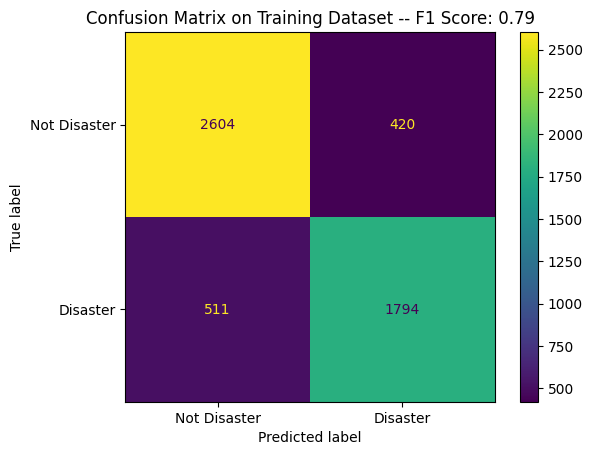

In [ ]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step


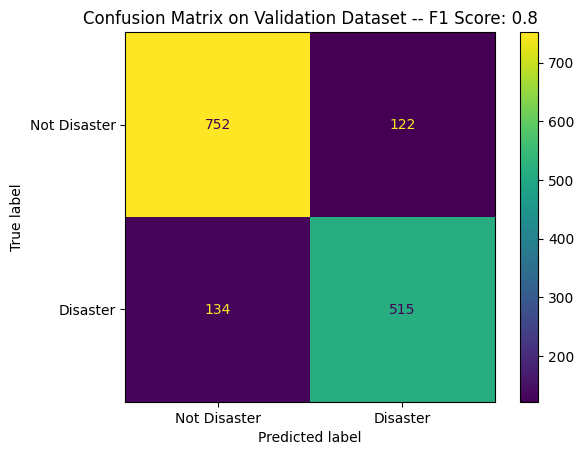

In [ ]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

<a id="9"></a>
# **<center><span style="color:#005dc4;">Predict test data</span></center>**

In [ ]:
prediction = np.argmax(classifier.predict(X_test), axis=1)
prediction

102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step


array([1, 1, 1, ..., 1, 1, 1])

<a id="10"></a>
# **<center><span style="color:#005dc4;">Submission</span></center>**

In [ ]:
submission = pd.read_csv("/content/sample_data/sample_submission.csv")
submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [ ]:
submission["target"] = prediction
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [ ]:
submission.to_csv("submission7.csv", index=False)

In [ ]:
#Libraries for visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#Libraries for formattting and handling text
import string
import re

#Library for nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS


#Library for Splitting Dataset
from sklearn.model_selection import train_test_split


#Libraries for NN
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout

from tensorflow.keras.utils import plot_model

#Library for evaluation
from sklearn import metrics
from functools import reduce
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import string

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def toclean_text(text):


    clean_text = [char for char in text if char not in string.punctuation]

    clean_text = ''.join(clean_text)


    return clean_text

In [ ]:
train['clean_text'] =train['text'].apply(toclean_text)

In [ ]:
train.head()

,id,keyword,location,text,target,length,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,45,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,39,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,85,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,60,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,59,Just got sent this photo from Ruby Alaska as s...


In [ ]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [ ]:
# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "
    return string

# Remove @ and mention, replace by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)

# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

# Remove all emojis, replace by EMOJI
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

# Replace some others smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)



In [ ]:
def clean_tweet(text):

    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)

    # replace abbreviations, @ and number
    text = replace_abbrev(text)
    text = remove_mention(text)
    text = remove_number(text)

    # Remove emojis / smileys
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)

    return text

In [ ]:
train["clean_text"] = train["clean_text"].apply(clean_tweet)

In [ ]:
# Define a function to remove stopwords from text

# The function takes one argument:
# - text: The input text from which stopwords will be removed.

# Tokenize the input text by splitting it into words and filter out words that are not in the list of English stopwords.
# The 'stopwords.words('english')' function from the NLTK library is used to obtain the list of English stopwords.

# Return the list of words after removing stopwords from the input text.


def toremove_stopword(text):
    remove_stopword = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return remove_stopword

In [ ]:
train.head()

,id,keyword,location,text,target,length,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,45,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,39,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,85,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,60,NUMBER people receive wildfires evacuation ord...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,59,Just got sent this photo from Ruby Alaska as s...


In [ ]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
train['clean_text'] = train['clean_text'].apply(toremove_stopword)

In [ ]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train['clean_text'].values)
X = tokenizer.texts_to_sequences(train['clean_text'].values)
X = pad_sequences(X)

In [ ]:
tokenizer.sequences_to_texts([[ 713,  154,   56, 1434,   14]])

['heavy evacuation life crying emergency']

In [ ]:
y = train['target']

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y, test_size = 0.2, random_state =41)

In [ ]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [ ]:
from tensorflow.keras.layers import Dropout
embed_dim = 32
lstm_out = 32

# Create a Sequential model for text classification
model = Sequential()

# Add an Embedding layer to convert input features into dense vectors
# 'max_features' is the maximum number of words in the vocabulary, and 'input_length' is the length of input sequences.
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(1,activation='sigmoid'))

adam = optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 19, 32)            96000     
                                                                 
 dropout_1 (Dropout)         (None, 19, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 104353 (407.63 KB)
Trainable params: 104353 (407.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
model.fit(X_train1, y_train1, epochs = 10, batch_size=32, validation_data=(X_test1, y_test1))

Epoch 1/10
191/191 [==============================] - 23s 102ms/step - loss: 0.5473 - accuracy: 0.7243 - val_loss: 0.4244 - val_accuracy: 0.8122
Epoch 2/10
191/191 [==============================] - 15s 78ms/step - loss: 0.3730 - accuracy: 0.8376 - val_loss: 0.4328 - val_accuracy: 0.8109
Epoch 3/10
191/191 [==============================] - 14s 74ms/step - loss: 0.3227 - accuracy: 0.8673 - val_loss: 0.4648 - val_accuracy: 0.8030
Epoch 4/10
191/191 [==============================] - 14s 74ms/step - loss: 0.2803 - accuracy: 0.8831 - val_loss: 0.5181 - val_accuracy: 0.7892
Epoch 5/10
191/191 [==============================] - 14s 73ms/step - loss: 0.2429 - accuracy: 0.8982 - val_loss: 0.6048 - val_accuracy: 0.7774
Epoch 6/10
191/191 [==============================] - 14s 73ms/step - loss: 0.2117 - accuracy: 0.9097 - val_loss: 0.7363 - val_accuracy: 0.7617
Epoch 7/10
191/191 [==============================] - 14s 73ms/step - loss: 0.1959 - accuracy: 0.9163 - val_loss: 0.7266 - val_accuracy

In [ ]:
  y_pred = model.predict(X_test1).round()

48/48 [==============================] - 1s 6ms/step


In [ ]:
train_accuracy = round(metrics.accuracy_score(y_train1,model.predict(X_train1).round())*100)
train_accuracy

191/191 [==============================] - 1s 6ms/step


96

In [ ]:
print('Accuracy  is  : ', (metrics.accuracy_score(y_test1, y_pred)))
print('Recall  is    : ', (metrics.recall_score(y_test1, y_pred)))
print('Precision  is : ', (metrics.precision_score(y_test1, y_pred)))
print("f1             :",(metrics.f1_score(y_test1, y_pred)))

Accuracy  is  :  0.7550886408404465
Recall  is    :  0.7210365853658537
Precision  is :  0.7134238310708899
f1             : 0.7172100075815012


In [ ]:
conm = confusion_matrix(y_test1,y_pred)
conm

array([[677, 190],
       [183, 473]])

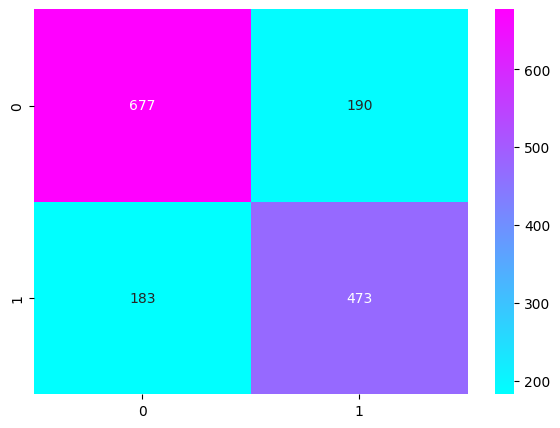

In [ ]:
plt.figure(figsize=(7, 5))
sns.heatmap(conm, annot=True, fmt='d', cmap='cool')
plt.show()

In [ ]:
# Generate and print a classification report for model evaluation

# The 'classification_report' function computes and displays a detailed classification report.
# It takes two arguments:
# - 'y_test1': The true labels from the test dataset.
# - 'y_pred': The predicted labels generated by the model.

# The classification report provides metrics such as precision, recall, F1-score, and support for each class.
# It's useful for evaluating the model's performance on a classification task.

print(classification_report(y_test1 , y_pred))

              precision    recall  f1-score   support

           0       0.79      0.78      0.78       867
           1       0.71      0.72      0.72       656

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523

